> ### Hi i am Hye ram from South Korea, personally into this data. 
> 
> ### As recent survey, almost half of Korean people suffers from depression. 
> ### With this background, i focused on Predicting Depression of DASS and evaluate it following their scoring guide.
> 
> ### For this, i used LinearRegression, RandomForest, SVM, XGBRegressor, Logistic Regression. I hope this would be helpful for your work. Thanks :)  
[Presentation Project with this data, mostly in Korean](https://docs.google.com/presentation/d/1h_Havpr1ObxcyurwuPPRY4_TA2AuDbepF16-CFYzZ-0/edit?usp=sharing)


# 1.Understanding Data

# 1.1 Data load

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
df = pd.read_csv('../input/depression-anxiety-stress-scales/DASS_data_21.02.19/data.csv', error_bad_lines = False, warn_bad_lines = False, sep=r'	')
codebook = open('../input/depression-anxiety-stress-scales/DASS_data_21.02.19/codebook.txt', 'r').read()



/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
import os
import time
import shap
import random
import xgboost
import numpy as np
import pandas as pd
from umap import UMAP
import networkx as nx
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import roc_curve, precision_recall_curve

import warnings; warnings.filterwarnings("ignore")

df


,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,screensize,uniquenetworklocation,hand,religion,orientation,race,voted,married,familysize,major
0,4,28,3890,4,25,2122,2,16,1944,4,...,1,1,1,12,1,10,2,1,2,NaN
1,4,2,8118,1,36,2890,2,35,4777,3,...,2,1,2,7,0,70,2,1,4,NaN
2,3,7,5784,1,33,4373,4,41,3242,1,...,2,1,1,4,3,60,1,1,3,NaN
3,2,23,5081,3,11,6837,2,37,5521,1,...,2,1,2,4,5,70,2,1,5,biology
4,2,36,3215,2,13,7731,3,5,4156,4,...,2,2,3,10,1,10,2,1,4,Psychology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39770,2,31,3287,1,5,2216,3,29,3895,2,...,2,1,1,2,4,60,2,1,2,NaN
39771,3,14,4792,4,41,2604,3,15,2668,4,...,1,1,1,10,0,10,2,1,4,Mathematic
39772,2,1,25147,1,4,4555,2,14,3388,1,...,2,1,1,7,1,30,1,2,3,Computer Science
39773,3,36,4286,1,34,2736,2,10,5968,2,...,2,1,1,6,1,60,1,1,2,History


# 1.2 Null Check

In [3]:
df.isnull().sum()

Q1A               0
Q1I               0
Q1E               0
Q2A               0
Q2I               0
              ...  
race              0
voted             0
married           0
familysize        0
major         11403
Length: 172, dtype: int64

# 1.3 describe

In [4]:
df.describe()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,age,screensize,uniquenetworklocation,hand,religion,orientation,race,voted,married,familysize
count,39775.000000,39775.000000,3.977500e+04,39775.000000,39775.000000,3.977500e+04,39775.000000,39775.000000,3.977500e+04,39775.000000,...,39775.000000,39775.000000,39775.000000,39775.00000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000
mean,2.619485,21.555977,6.970591e+03,2.172269,21.248070,5.332376e+03,2.226097,21.583004,7.426446e+03,1.950170,...,23.612168,1.274519,1.200025,1.13516,7.555852,1.642992,31.312885,1.705795,1.159547,3.510270
std,1.032117,12.133621,8.670513e+04,1.111563,12.125288,2.651361e+04,1.038526,12.115637,1.587024e+05,1.042218,...,21.581722,0.446277,0.400024,0.40030,3.554395,1.351362,25.871272,0.473388,0.445882,2.141518
min,1.000000,1.000000,1.800000e+02,1.000000,1.000000,1.760000e+02,1.000000,1.000000,-1.081400e+04,1.000000,...,13.000000,1.000000,1.000000,0.00000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000
25%,2.000000,11.000000,2.664000e+03,1.000000,11.000000,2.477000e+03,1.000000,11.000000,2.857000e+03,1.000000,...,18.000000,1.000000,1.000000,1.00000,4.000000,1.000000,10.000000,1.000000,1.000000,2.000000
50%,3.000000,22.000000,3.609000e+03,2.000000,21.000000,3.511000e+03,2.000000,22.000000,3.898000e+03,2.000000,...,21.000000,1.000000,1.000000,1.00000,10.000000,1.000000,10.000000,2.000000,1.000000,3.000000
75%,4.000000,32.000000,5.358000e+03,3.000000,32.000000,5.216000e+03,3.000000,32.000000,5.766000e+03,3.000000,...,25.000000,2.000000,1.000000,1.00000,10.000000,2.000000,60.000000,2.000000,1.000000,4.000000
max,4.000000,42.000000,1.210228e+07,4.000000,42.000000,2.161057e+06,4.000000,42.000000,2.858269e+07,4.000000,...,1998.000000,2.000000,2.000000,3.00000,12.000000,5.000000,70.000000,2.000000,3.000000,133.000000


In [5]:
df.describe().T.style.background_gradient(cmap = 'Greens')
#A= answer (평가),E= time to estimate (점수 메기는데에 걸린 시간), I= location of question 질문의 위치
#This response is stored in variable A (e.g. Q1A). 
#Also recorded was the time taken in milliseconds to answer that question (E) 
#and that question's position in the survey (I).
#앤서랑 타겟/테스트 검증 이렇게 세개로 나누고 모델 별로 다 돌려보기  

,count,mean,std,min,25%,50%,75%,max
Q1A,39775.000000,2.619485,1.032117,1.000000,2.000000,3.000000,4.000000,4.000000
Q1I,39775.000000,21.555977,12.133621,1.000000,11.000000,22.000000,32.000000,42.000000
Q1E,39775.000000,6970.590798,86705.131996,180.000000,2664.000000,3609.000000,5358.000000,12102282.000000
Q2A,39775.000000,2.172269,1.111563,1.000000,1.000000,2.000000,3.000000,4.000000
Q2I,39775.000000,21.248070,12.125288,1.000000,11.000000,21.000000,32.000000,42.000000
Q2E,39775.000000,5332.375839,26513.611044,176.000000,2477.000000,3511.000000,5216.000000,2161057.000000
Q3A,39775.000000,2.226097,1.038526,1.000000,1.000000,2.000000,3.000000,4.000000
Q3I,39775.000000,21.583004,12.115637,1.000000,11.000000,22.000000,32.000000,42.000000
Q3E,39775.000000,7426.446084,158702.352874,-10814.000000,2857.000000,3898.000000,5766.000000,28582689.000000
Q4A,39775.000000,1.950170,1.042218,1.000000,1.000000,2.000000,3.000000,4.000000


# 1.4 Visualization

In [6]:
df.corr().style.background_gradient(cmap = 'Greens')
#A=평가,E=점수 메기는데에 걸린 시간, I=참가자 포지션 
#S (Stress) Q1, 6, 8, 11, 12, 14, 18
#target= ['Q1A','Q6A','Q8A','Q11A','Q12A','Q14A','Q18A']
         #'upsetbyt' 'over_react' 'd_relax' 'upset_easily''impatient''touchy'    

# 1.5 Correlation

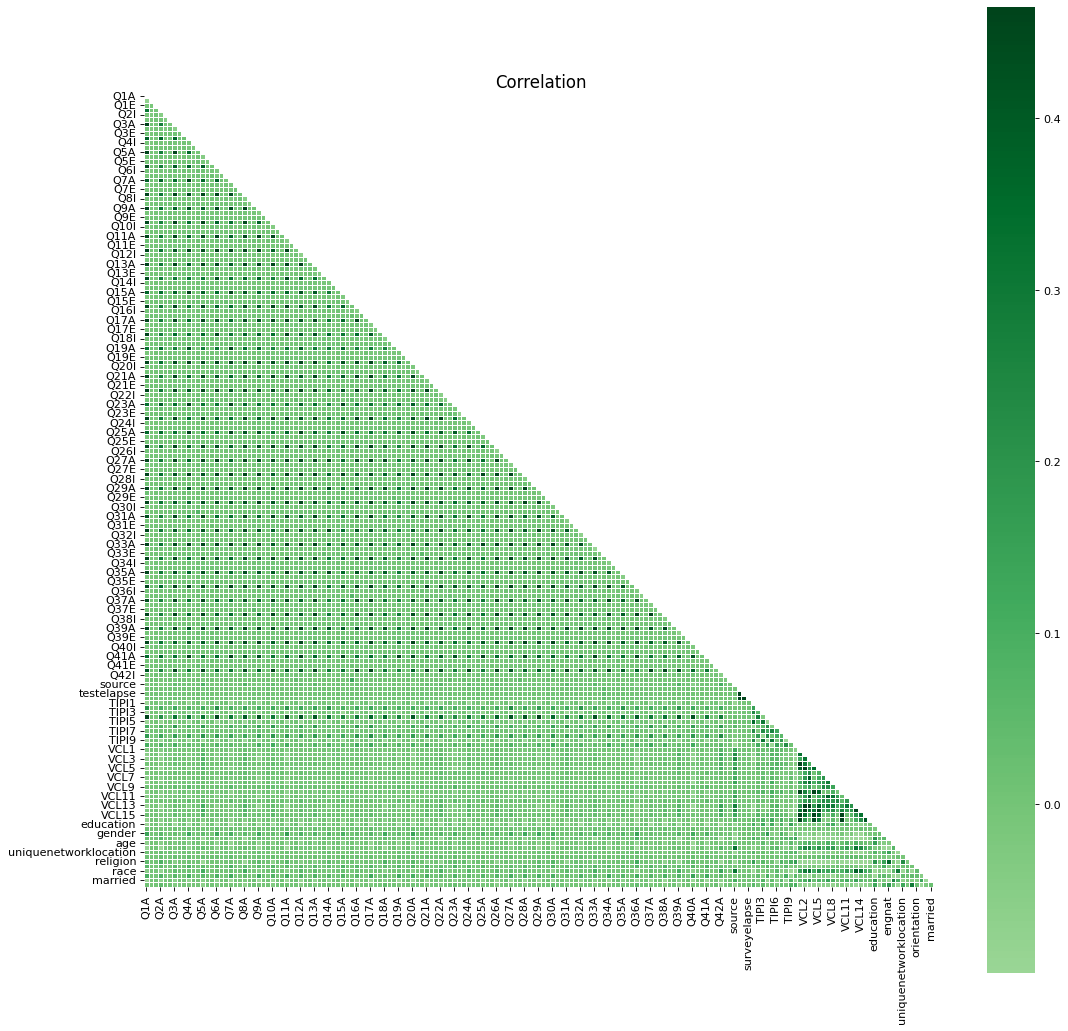

In [7]:
plt.figure(figsize=(16,16),dpi=80)
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap = 'Greens', robust=True, center=0, square=True, linewidths=.5)
plt.title('Correlation', fontsize=15)
plt.show()

# 1.5 _ X / Y 의 파악 

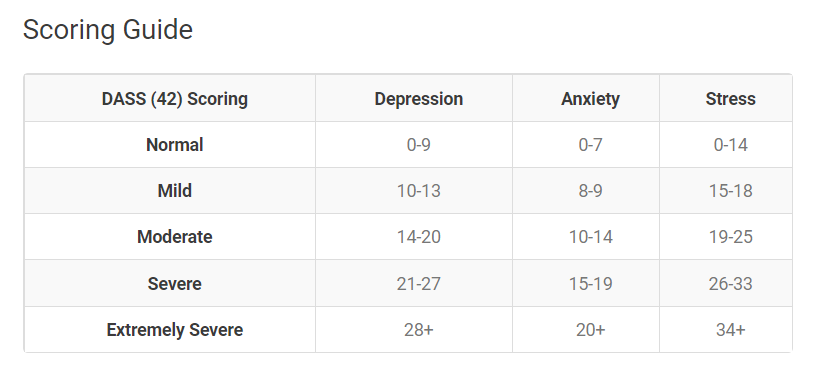

# 2. Data preparation 

# 2.1 Feature engineering +EDA... etc

In [8]:
#major 지우고 (범주형 오버),상관 없는 피쳐 지우고, 각 타겟에 맞는 특성 피쳐
#depression으로 모델 일단 구축 
dfd= df[['Q3A','Q5A','Q10A','Q13A','Q16A','Q17A','Q21A','Q24A','Q26A','Q31A','Q34A','Q37A','Q38A','Q42A',
         'TIPI1','TIPI2','TIPI3','TIPI4','TIPI5','TIPI6','TIPI7','TIPI8','TIPI9','TIPI10',
         'education','urban','gender','engnat','age','hand','religion','orientation','race','voted','married','familysize']]
#dfa= df[['Q2A','Q4A','Q7A','Q9A','Q12A','Q15A','Q19A','Q20A','Q23A','Q25A','Q28A','Q30A','Q36A','Q40A','Q41A','education','urban','gender','engnat','age','hand','religion','race','voted','married','familysize']]
#dfs= df[['Q1A','Q6A','Q8A','Q11A','Q12A','Q14A','Q18A','Q22A','Q27A','Q29A','Q32A','Q33A','Q35A','Q39A','education','urban','gender','engnat','age','hand','religion','race','voted','married','familysize']]

#VCL 단어 표현력 테스트 합계  #() !이고 숫자 앞에는 =하나만 쓰나봐 
#if 'VCL6' 'VCL9' 'VCL12' 중에 하나라도 1이면 그 데이터 지워라 > 이건 어떻게할지 계속 고민하겠어  
dfd1=df.loc[(df['VCL6'] !=1)&(df['VCL9'] !=1)]
dfd=dfd1.loc[df['VCL12'] !=1]

dfd['VCL']=df['VCL1']+df['VCL2']+df['VCL3']+df['VCL4']+df['VCL5']+df['VCL7']+df['VCL8']+df['VCL10']+df['VCL11']+df['VCL13']+df['VCL14']+df['VCL15']+df['VCL16']
#dfa['VCL']=df['VCL1']+df['VCL2']+df['VCL3']+df['VCL4']+df['VCL5']+df['VCL7']+df['VCL8']+df['VCL10']+df['VCL11']+df['VCL13']+df['VCL14']+df['VCL15']+df['VCL16']
#dfs['VCL']=df['VCL1']+df['VCL2']+df['VCL3']+df['VCL4']+df['VCL5']+df['VCL7']+df['VCL8']+df['VCL10']+df['VCL11']+df['VCL13']+df['VCL14']+df['VCL15']+df['VCL16']

#depression_target 설정 
dfd['d_score']=df['Q3A']+df['Q5A']+df['Q10A']+df['Q13A']+df['Q16A']+df['Q17A']+df['Q21A']+df['Q24A']+df['Q26A']+df['Q31A']+df['Q34A']+df['Q38A']+df['Q42A']
dfd.head(20)
#dfd['d_score']>=21
dfd= dfd[['d_score','VCL','TIPI1','TIPI2','TIPI3','TIPI4','TIPI5','TIPI6','TIPI7','TIPI8','TIPI9','TIPI10',
         'education','urban','gender','engnat','age','hand','religion','orientation','race','voted','married','familysize','screensize']]
dfd

,d_score,VCL,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,...,engnat,age,hand,religion,orientation,race,voted,married,familysize,screensize
0,40,8,1,5,7,7,7,7,7,5,...,2,16,1,12,1,10,2,1,2,1
1,34,8,6,5,4,7,5,4,7,7,...,1,16,2,7,0,70,2,1,4,2
2,49,7,2,5,2,2,5,6,5,5,...,2,17,1,4,3,60,1,1,3,2
3,28,7,1,1,7,4,6,4,6,1,...,1,13,2,4,5,70,2,1,5,2
4,43,10,2,5,3,6,5,5,5,6,...,2,19,3,10,1,10,2,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,27,9,6,5,4,5,6,3,5,2,...,1,16,1,1,1,70,2,1,3,2
39770,46,9,2,2,3,5,6,5,5,3,...,1,16,1,2,4,60,2,1,2,2
39772,17,6,6,6,7,5,6,3,6,1,...,1,48,1,7,1,30,1,2,3,2
39773,29,11,1,6,5,7,3,5,3,5,...,1,20,1,6,1,60,1,1,2,2


In [9]:
dfd[['VCL','d_score']].groupby(['VCL'],as_index=False).mean().sort_values(by='d_score',ascending=False)

,VCL,d_score
0,0,33.915612
9,9,33.341935
10,10,33.153240
8,8,33.097194
3,3,32.580469
5,5,32.549097
6,6,32.408409
4,4,32.345274
7,7,32.262460
11,11,32.196944


In [10]:
#!
dfd[['education','d_score']].groupby(['education'],as_index=False).mean().sort_values(by='d_score',ascending=False)

,education,d_score
1,1,35.968722
2,2,33.779442
0,0,32.880562
3,3,31.352902
4,4,29.801964


In [11]:
dfd[['urban','d_score']].groupby(['urban'],as_index=False).mean().sort_values(by='d_score',ascending=False)

,urban,d_score
0,0,34.066860
3,3,32.866424
2,2,32.262237
1,1,32.201048


In [12]:
#!!!
dfd[['TIPI2','d_score']].groupby(['TIPI2'],as_index=False).mean().sort_values(by='d_score',ascending=False)

,TIPI2,d_score
7,7,37.667511
6,6,34.191972
0,0,32.627561
4,4,32.572472
5,5,32.254826
3,3,31.196813
2,2,30.617698
1,1,29.627099


In [13]:
#!!! de
dfd[['TIPI3','d_score']].groupby(['TIPI3'],as_index=False).mean().sort_values(by='d_score',ascending=False)

,TIPI3,d_score
1,1,40.018672
2,2,36.660408
3,3,34.665147
4,4,34.324173
0,0,32.278810
5,5,32.097409
7,7,30.159272
6,6,29.957624


In [14]:
#!!!
dfd[['TIPI4','d_score']].groupby(['TIPI4'],as_index=False).mean().sort_values(by='d_score',ascending=False)

,TIPI4,d_score
7,7,39.300920
6,6,34.062813
0,0,30.453271
5,5,29.465266
4,4,27.442942
3,3,26.854442
2,2,24.880918
1,1,23.606471


In [15]:
dfd[['age','d_score']].groupby(['age'],as_index=False).mean().sort_values(by='d_score',ascending=False)

,age,d_score
70,99,52.0
75,1993,51.0
76,1996,48.0
72,117,41.0
74,1991,39.0
...,...,...
69,89,21.0
73,223,18.0
77,1998,16.0
63,76,15.0


In [16]:
dfd[['race','d_score']].groupby(['race'],as_index=False).mean().sort_values(by='d_score',ascending=False)

,race,d_score
4,50,35.458333
1,20,34.863158
3,40,33.846154
5,60,33.811912
2,30,33.000000
6,70,32.515030
0,10,31.972983


In [17]:
#kaggle task NOPE  xx
dfd[['screensize','d_score']].groupby(['screensize'],as_index=False).mean().sort_values(by='d_score',ascending=False)

,screensize,d_score
0,1,32.647896
1,2,32.238042


In [18]:
dfd=dfd.loc[(dfd['age']>0)&(dfd['age']<90)]

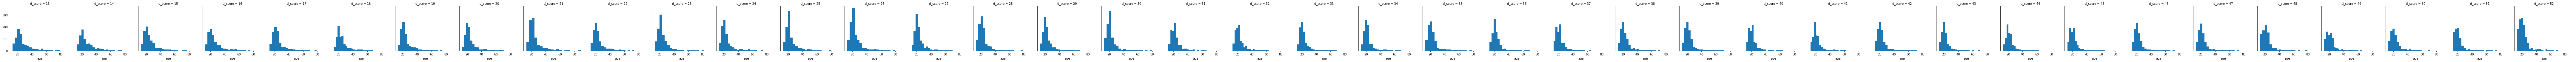

In [19]:
g = sns.FacetGrid(dfd, col='d_score')
g.map(plt.hist, 'age', bins=20)

In [20]:
dfd[['age','d_score']].groupby(['age'],as_index=False).mean().sort_values(by='d_score',ascending=False)

,age,d_score
1,14,37.885180
57,70,37.777778
0,13,37.661836
2,15,36.305626
3,16,35.495000
...,...,...
62,75,22.125000
61,74,22.000000
69,89,21.000000
63,76,15.000000


In [21]:
dfd['AgeBand'] = pd.cut(dfd['age'], 4)
dfd[['AgeBand','d_score']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,d_score
0,"(12.924, 32.0]",32.901911
1,"(32.0, 51.0]",29.364255
2,"(51.0, 70.0]",29.409786
3,"(70.0, 89.0]",25.155556


In [22]:
dfd['AgeBand']=0
dfd.loc[(dfd['age']>12) & (dfd['age']<= 32),'AgeBand'] = 3
dfd.loc[(dfd['age']>32) & (dfd['age']<= 51),'AgeBand'] = 2
dfd.loc[(dfd['age']>51) & (dfd['age']<= 70),'AgeBand'] = 1
dfd.loc[dfd['age']>70,'AgeBand']=0
dfd.head()

,d_score,VCL,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,...,age,hand,religion,orientation,race,voted,married,familysize,screensize,AgeBand
0,40,8,1,5,7,7,7,7,7,5,...,16,1,12,1,10,2,1,2,1,3
1,34,8,6,5,4,7,5,4,7,7,...,16,2,7,0,70,2,1,4,2,3
2,49,7,2,5,2,2,5,6,5,5,...,17,1,4,3,60,1,1,3,2,3
3,28,7,1,1,7,4,6,4,6,1,...,13,2,4,5,70,2,1,5,2,3
4,43,10,2,5,3,6,5,5,5,6,...,19,3,10,1,10,2,1,4,2,3


In [23]:
#personality 점수 높을수록 우울 업업
dfd['personality']=dfd['TIPI2']+dfd['TIPI4']+dfd['TIPI6']+dfd['TIPI8']+dfd['TIPI10']-dfd['TIPI1']-dfd['TIPI3']-dfd['TIPI5']-dfd['TIPI7']-dfd['TIPI9']

# target 설정 

In [24]:
#target은'd_score'
#dfd['d_score']>=21
dfd['d_severe']=0
dfd.loc[(dfd['d_score']<21),'d_severe']=0
dfd.loc[(dfd['d_score']>=21),'d_severe']=1
dfd.head()

,d_score,VCL,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,...,religion,orientation,race,voted,married,familysize,screensize,AgeBand,personality,d_severe
0,40,8,1,5,7,7,7,7,7,5,...,12,1,10,2,1,2,1,3,2,1
1,34,8,6,5,4,7,5,4,7,7,...,7,0,70,2,1,4,2,3,5,1
2,49,7,2,5,2,2,5,6,5,5,...,4,3,60,1,1,3,2,3,3,1
3,28,7,1,1,7,4,6,4,6,1,...,4,5,70,2,1,5,2,3,-15,1
4,43,10,2,5,3,6,5,5,5,6,...,10,1,10,2,1,4,2,3,7,1


In [25]:
dfd.d_severe.value_counts().to_frame().style.background_gradient(cmap='summer')

,d_severe
1,28184
0,6391


In [26]:
dfd= dfd[['d_severe','AgeBand','VCL','personality','screensize',
         'education','urban','gender','engnat','age','hand','religion','orientation','race','voted','married','familysize']]
dfd

,d_severe,AgeBand,VCL,personality,screensize,education,urban,gender,engnat,age,hand,religion,orientation,race,voted,married,familysize
0,1,3,8,2,1,2,3,2,2,16,1,12,1,10,2,1,2
1,1,3,8,5,2,2,3,2,1,16,2,7,0,70,2,1,4
2,1,3,7,3,2,2,3,2,2,17,1,4,3,60,1,1,3
3,1,3,7,-15,2,1,3,2,1,13,2,4,5,70,2,1,5
4,1,3,10,7,2,3,2,2,2,19,3,10,1,10,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,1,3,9,-4,2,1,2,2,1,16,1,1,1,70,2,1,3
39770,1,3,9,2,2,2,2,1,1,16,1,2,4,60,2,1,2
39772,0,2,6,-11,2,3,2,2,1,48,1,7,1,30,1,2,3
39773,1,3,11,12,2,3,2,2,1,20,1,6,1,60,1,1,2


# baseline

In [27]:
#from sklearn import datasets, linear_model
#from sklearn.model_selection import train_test_split

train=dfd.sample(frac=0.75,random_state=1)
test=dfd.drop(train.index)
train.head()

,d_severe,AgeBand,VCL,personality,screensize,education,urban,gender,engnat,age,hand,religion,orientation,race,voted,married,familysize
10121,1,3,6,7,1,3,1,2,2,21,1,12,1,10,2,1,2
37803,1,3,4,-1,1,2,1,2,2,20,1,10,5,10,2,1,6
21867,1,3,6,3,1,3,3,2,2,28,1,10,1,70,1,2,4
33070,1,3,8,-14,1,4,3,2,2,22,1,10,1,70,2,1,3
5476,0,3,6,-1,1,2,3,2,2,19,1,10,0,10,2,1,4


In [28]:
len(train),len(test)

(25931, 8644)

In [29]:
train['d_severe'].mean()

0.8148933708688443

In [30]:
#label 정의 
target='d_severe'
y_train=train[target]
y_test=test[target]

In [31]:
#dscore mean으로 예측 (기준모델)
predict=y_train.mean()
predict

0.8148933708688443

In [32]:
#기준모델로 훈련 에러 (MAE 계산)#나중에뜯어보기
from sklearn.metrics import mean_absolute_error
y_pred=[predict]*len(y_train)
mae=mean_absolute_error(y_train,y_pred)
print(f'훈련에러:{mae:.2f}')


훈련에러:0.30


In [33]:
# 테스트 에러(MAE)
y_pred = [predict] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:.2f}')

테스트 에러: 0.30


In [34]:
#(predict,)*len(y_train) #튜플과 리스트의 차이 

# 2. 2  Data Split 

In [35]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((20744, 17), (5187, 17), (8644, 17))

# 3. Modeling 

(1) Y 값이 연속된 숫자 : Regression / Y 값이 숫자 X : Classifier
분류로 간다!!! 점수 분류된 그 표로 간다..!


In [36]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [37]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

<function matplotlib.pyplot.show(close=None, block=None)>

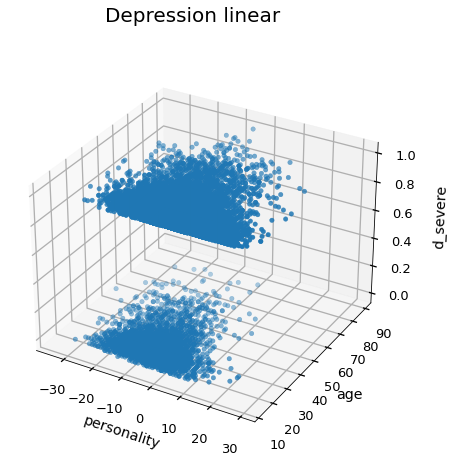

In [38]:
#다중 선형 회귀 그래프로 확인 
from matplotlib import style
import matplotlib.pyplot as plt
style.use('seaborn-talk')
fig=plt.figure()
ax=fig.gca(projection='3d')
ax.scatter(train['personality'],train['age'],train['d_severe'])
ax.set_xlabel('personality', labelpad=12)
ax.set_ylabel('age', labelpad=10)
ax.set_zlabel('d_severe', labelpad=20)
plt.suptitle('Depression linear',fontsize=20)
plt.show


In [39]:
#다중모델 학습 특성
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X_train=train[features]
X_test[features]
#fit
model.fit(X_train,y_train)
y_pred=model.predict(X_train)
mae=mean_absolute_error(y_train,y_pred)
print(f'훈련에러:{mae:2f}')
#test
y_pred=model.predict(X_test)
mae=mean_absolute_error(y_test,y_pred)
print(f'테스트 에러:{mae:2f}')

훈련에러:0.268773
테스트 에러:0.268884


In [40]:
from sklearn.tree import DecisionTreeClassifier
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=1, criterion='entropy')
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))


검증 정확도:  0.7501445922498554


In [41]:
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    RandomForestClassifier(n_jobs=-1, random_state=10, oob_score=True)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.8282244071717756


In [42]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    RandomForestClassifier(min_samples_leaf=10, n_jobs=-1, random_state=10, oob_score=True)
)

pipe.fit(X_train, y_train)
print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))

훈련 정확도 0.8560065561126109
검증 정확도 0.8370927318295739


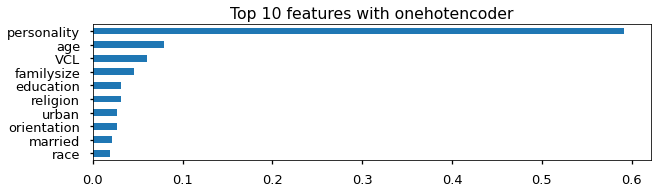

In [43]:
import matplotlib.pyplot as plt

# 특성 중요도(onehot)
rf = pipe.named_steps['randomforestclassifier']
colnames = pipe.named_steps['onehotencoder'].get_feature_names()
importances = pd.Series(rf.feature_importances_, colnames)

n = 10
plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with onehotencoder')
importances.sort_values()[-n:].plot.barh();

In [44]:
dfd= dfd[['d_severe','AgeBand','VCL','personality','education','urban','age','religion','orientation','familysize']]
print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))

훈련 정확도 0.8560065561126109
검증 정확도 0.8370927318295739


In [45]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8159416936603424

In [46]:
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    RandomForestClassifier(min_samples_leaf=10,max_depth =10, random_state=10, oob_score=True)
)
from sklearn.model_selection import cross_val_score
k = 3

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores)

pipe.fit(X_train, y_train)
print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))

MAE for 3 folds: [0.17353579 0.1670282  0.16632919]
훈련 정확도 0.8487273428461242
검증 정확도 0.8382494698284172


In [47]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8159416936603424

In [48]:
from sklearn.metrics import classification_report
# train 학습, 검증셋 정확도
pipe.fit(X_train, y_train)
print('검증 정확도', pipe.score(X_val, y_val))

print(classification_report(y_val, pipe.predict(X_val)))

검증 정확도 0.8382494698284172
              precision    recall  f1-score   support

           0       0.67      0.25      0.37       960
           1       0.85      0.97      0.91      4227

    accuracy                           0.84      5187
   macro avg       0.76      0.61      0.64      5187
weighted avg       0.82      0.84      0.81      5187



In [49]:
from sklearn.metrics import accuracy_score
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

print(classification_report(y_pred, y_val))

검증 정확도:  0.8382494698284172
              precision    recall  f1-score   support

           0       0.25      0.67      0.37       363
           1       0.97      0.85      0.91      4824

    accuracy                           0.84      5187
   macro avg       0.61      0.76      0.64      5187
weighted avg       0.92      0.84      0.87      5187



In [50]:
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import svm 

LR = LogisticRegression(max_iter=1000,C=0.175,random_state=42)
LR.fit(X_train,y_train)
lr_training_accuracy = LR.score(X_train, y_train)
lr_predictions = LR.predict(X_test)
lr_predictions = [int(x) for x in lr_predictions]

xgboost = XGBRegressor(learning_rate=0.005,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:squarederror',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

xgb = xgboost.fit(X_train,y_train)
xgb_training_accuracy = xgb.score(X_train,y_train)
xgb_predictions = xgb.predict(X_test)
xgb_predictions = [round(x) for x in xgb_predictions]

print("Logistic Regression training accuracy: %.2f%%" % (lr_training_accuracy * 100.0))
print("\nXGB training accuracy: %.2f%%" % (xgb_training_accuracy * 100.0))

Logistic Regression training accuracy: 83.39%

XGB training accuracy: 26.26%


In [51]:
from category_encoders import OneHotEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor

pipe = make_pipeline(
    # TargetEncoder: 범주형 변수 인코더로, 타겟값을 특성의 범주별로 평균내어 그 값으로 인코딩
    TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)
)

k = 3

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores)

MAE for 3 folds: [0.24625579 0.24089621 0.23960946]


In [52]:
#features
#dfd= df[['Q3A','Q5A','Q10A','Q13A','Q16A','Q17A','Q21A','Q24A','Q26A','Q31A','Q34A','Q37A','Q38A','Q42A','education','urban','gender','engnat','age','hand','religion','race','voted','married','familysize']]
#dfa= df[['Q2A','Q4A','Q7A','Q9A','Q12A','Q15A','Q19A','Q20A','Q23A','Q25A','Q28A','Q30A','Q36A','Q40A','Q41A','education','urban','gender','engnat','age','hand','religion','race','voted','married','familysize']]
#dfs= df[['Q1A','Q6A','Q8A','Q11A','Q12A','Q14A','Q18A','Q22A','Q27A','Q29A','Q32A','Q33A','Q35A','Q39A','education','urban','gender','engnat','age','hand','religion','race','voted','married','familysize']]

#점수 내기 
#d=df['Q3A']+df['Q5A']+df['Q10A']+df['Q13A']+df['Q16A']+df['Q17A']+df['Q21A']+df['Q24A']+df['Q26A']+df['Q31A']+df['Q37A']+df['Q38A']+df['Q42A']
#a=df['Q2A']+df['Q4A']+df['Q7A']+df['Q9A']+df['Q12A']+df['Q15A']+df['Q19A']+df['Q20A']+df['Q23A']+df['Q25A']+df['Q28A']+df['Q30A']+df['Q36A']+df['Q40A']+df['Q41A']
#s=df['Q1A']+df['Q6A']+df['Q8A']+df['Q11A']+df['Q12A']+df['Q14A']+df['Q18A']+df['Q22A']+df['Q27A']+df['Q29A']+df['Q32A']+df['Q33A']+df['Q35A']+df['Q39A']

